In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import sklearn
from random import random
from sklearn.model_selection import cross_validate
import matplotlib
from waveform_methods import binning
import pandas as pd

from scipy.stats import norm
import pickle
from statistics import mode
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale

In [2]:
file = uproot.open('/home/andy/12360.root')
file2 = uproot.open('/home/andy/12362.root')
log_normal = np.load('log_normal.npz',allow_pickle=True,encoding='latin1')['arr_0'].item()

In [3]:
print(file['Stoch_Reco'].keys())

[b'Run', b'Event', b'SubEvent', b'SubEventStream', b'SubEventStream_String', b'exists', b'eloss_1000', b'eloss_1500', b'eloss_1600', b'eloss_1700', b'eloss_1800', b'eloss_1900', b'eloss_2000', b'eloss_2100', b'eloss_2200', b'eloss_2300', b'eloss_2400', b'eloss_3000', b'a_estim', b'a_estim_err', b'e0_estim', b'e0_estim_err', b'stoch_energy', b'rel_stoch_energy', b'total_stoch_energy', b'total_rel_stoch_energy', b'highest_stoch_energy', b'highest_rel_stoch_energy', b'chi2', b'chi2_red', b'stoch_depth', b'n_he_stoch', b'fit_status', b'fit_status_String']


In [4]:
Eloss_keys = file['Stoch_Reco'].keys()[6:18]
for i in range(len(Eloss_keys)):
    if i == 0:
        Eloss1 = file['Stoch_Reco'][Eloss_keys[i]].array()
    else:
        Eloss1 += file['Stoch_Reco'][Eloss_keys[i]].array()
Eloss1 = Eloss1/len(Eloss_keys)

Eloss_keys = file2['Stoch_Reco'].keys()[6:18]
for i in range(len(Eloss_keys)):
    if i == 0:
        Eloss2 = file2['Stoch_Reco'][Eloss_keys[i]].array()
    else:
        Eloss2 += file2['Stoch_Reco'][Eloss_keys[i]].array()
Eloss2 = Eloss2/len(Eloss_keys)

Eloss = np.append(Eloss1,Eloss2)

In [5]:
cut = []
for i in file['IT73AnalysisInIceQualityCuts'].keys()[6:11]:
    cut.append(file['IT73AnalysisInIceQualityCuts'][i].array())
cut2 = list(zip(cut))
for i in range(len(cut2)):
    if i == 0:
        final_cut = cut2[i][0]
    else:
        final_cut = [j and k for j,k in zip(final_cut,cut2[i][0])]
        
cut = []
for i in file2['IT73AnalysisInIceQualityCuts'].keys()[6:11]:
    cut.append(file2['IT73AnalysisInIceQualityCuts'][i].array())
cut2 = list(zip(cut))
for i in range(len(cut2)):
    if i == 0:
        final_cut2 = cut2[i][0]
    else:
        final_cut2 = [j and k for j,k in zip(final_cut,cut2[i][0])]
        
in_ice_cuts = np.append(final_cut,final_cut2)

In [6]:
Xmax1 = file['MCPrimaryInfo']['ghMaxDepth'].array()
valueDepth = file['MCPrimaryInfo']['longNumCharged'].array()
Depth1 = file['MCPrimaryInfo']['longDepth'].array()
chi2_1 = file['CurvatureOnlyParams']['chi2_time'].array()
red1 = file['MCPrimaryInfo']['ghRedChiSqr'].array()
mass1 = [1 for i in range(len(red1))]
        
Xmax2 = file2['MCPrimaryInfo']['ghMaxDepth'].array()
valueDepth = file2['MCPrimaryInfo']['longNumCharged'].array()
Depth2 = file2['MCPrimaryInfo']['longDepth'].array()
chi2_2 = file2['CurvatureOnlyParams']['chi2_time'].array()
red2 = file2['MCPrimaryInfo']['ghRedChiSqr'].array()
mass2 = [4 for i in range(len(red2))]


In [7]:
S125_1 = file['LaputopParams']['s125'].array()
S125_2 = file2['LaputopParams']['s125'].array()
A1 = file['CurvatureOnlyParams']['A'].array()
A2 = file2['CurvatureOnlyParams']['A'].array()
D1 = file['CurvatureOnlyParams']['D'].array()
D2 = file2['CurvatureOnlyParams']['D'].array()
N1 = file['CurvatureOnlyParams']['N'].array()
N2 = file2['CurvatureOnlyParams']['N'].array()
beta1 = file['LaputopParams']['beta'].array()
beta2 = file2['LaputopParams']['beta'].array()
zenith1 = file['Laputop']['zenith'].array()
zenith2 = file2['Laputop']['zenith'].array()
energy1 = file['MCPrimary']['energy'].array()
energy2 = file2['MCPrimary']['energy'].array()
stoch1_1 = file['Stoch_Reco']['n_he_stoch'].array()
stoch1_2 = file2['Stoch_Reco']['n_he_stoch'].array()
stoch2_1 = file['Stoch_Reco2']['n_he_stoch'].array()
stoch2_2 = file2['Stoch_Reco2']['n_he_stoch'].array()

slc_charge1 = file['LaputopSLCPE']['charge'].array()
slc_charge2 = file2['LaputopSLCPE']['charge'].array()

slc_charge1 = [np.sum(i[np.isnan(i)==False]) for i in slc_charge1]
slc_charge2 = [np.sum(i[np.isnan(i)==False]) for i in slc_charge2]

hlc_charge1 = file['LaputopHLCPE']['charge'].array()
hlc_charge2 = file2['LaputopHLCPE']['charge'].array()

hlc_charge1 = [np.sum(i[np.isnan(i) ==False]) for i in hlc_charge1]
hlc_charge2 = [np.sum(i[np.isnan(i)==False]) for i in hlc_charge2]

Qtot1 = [i+j for i,j in zip(slc_charge1,hlc_charge1)]
Qtot2 = [i+j for i,j in zip(slc_charge2,hlc_charge2)]

In [8]:
A = np.append(A1,A2)
D = np.append(D1,D2)
N = np.append(N1,N2)
S125 = np.log10(np.append(S125_1,S125_2))
beta = np.log10(np.append(beta1,beta2))
chi2 = np.append(chi2_1,chi2_2)
red = np.append(red1,red2)
zenith = np.cos(np.append(zenith1,zenith2))
Xmax = np.append(Xmax1,Xmax2)
red = np.append(red1,red2)
mass = np.append(mass1,mass2)
slc_charge = np.append(slc_charge1,slc_charge2)
hlc_charge = np.append(hlc_charge1,hlc_charge2)
qtot = np.append(Qtot1,Qtot2)
stoch1 = np.append(stoch1_1,stoch1_2)
stoch2 = np.append(stoch2_1,stoch2_2)
for i in range(len(stoch1)):
    if not in_ice_cuts[i]:
        stoch1[i] = 0
        stoch2[i] = 0

energy_loss = Eloss
for i in range(len(energy_loss)):
    if ((energy_loss[i] != 0 and in_ice_cuts[i]) and np.isfinite(energy_loss[i])) and not np.isnan(energy_loss[i]):
        energy_loss[i] = np.log10(abs(energy_loss[i]))
    else:
        energy_loss[i] = 0
        
energy = np.log10(np.append(energy1,energy2))

s = log_normal['s']
m = log_normal['m']
fit_status = log_normal['fit_status']

for i in range(len(in_ice_cuts)):
    if fit_status[i] == True and in_ice_cuts[i] == False:
        in_ice_cuts[i] = False
    else:
        in_ice_cuts[i] = True

In [9]:
values = [mass[in_ice_cuts==False],
            A[in_ice_cuts==False],
            D[in_ice_cuts==False],
            N[in_ice_cuts==False],
            S125[in_ice_cuts==False],
            beta[in_ice_cuts==False],
            zenith[in_ice_cuts==False],
            chi2[in_ice_cuts==False],
            slc_charge[in_ice_cuts==False],
            hlc_charge[in_ice_cuts==False],
            qtot[in_ice_cuts==False]
            ]


In [10]:
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale

#model coinc:slc_charge,A,N,beta,energy_loss,stoch1,zenith
#model not coinc:slc_charge,beta,A,zenith
input_variable2_old = scale(np.array(list(zip(A,N,beta,S125,zenith,m,s)))[in_ice_cuts==False])
output_new_old = mass[in_ice_cuts==False]
energy_value = energy[in_ice_cuts==False]

index = range(len(output_new_old))

output,validation,output_mass,validation_mass = train_test_split(index,output_new_old,test_size=0.1,random_state=42)
        
validation_x = input_variable2_old[validation]
validation_y = output_new_old[validation]
validation_energy = energy_value[validation]
input_variable = np.array(input_variable2_old)[output]
output_new = np.array(output_new_old)[output]
energy_value = energy_value[output]
weights = np.array((qtot**0.5)[output])
index = np.array(range(len(weights)))

In [11]:
import keras
from keras import initializers,regularizers
from keras.layers import Dense, Dropout, Flatten, Input, Concatenate, LeakyReLU, BatchNormalization
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_math_ops as math_ops

Using TensorFlow backend.


In [12]:
train_index,test_index,train_labels,test_labels = train_test_split(index,output_new,test_size=0.2,random_state=42)

In [13]:
best_model = keras.callbacks.ModelCheckpoint('Mass_model_best.h5',
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto')
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [14]:
input_layer = Input(shape=(8,))

model1 = Dense(16,activation='sigmoid')(input_layer)

model1 = Dropout(rate=0.5)(model1)

model2 = Dense(16,activation='sigmoid')(model1)

predictions = Dense(1,activation='linear')(model2)

model = Model(inputs=input_layer,outputs=predictions)

opt = keras.optimizers.RMSprop(decay=1e-5)
#opt= keras.optimizers.Adam(decay=1e-5,amsgrad=True)  

model.compile(optimizer=opt , loss = 'mae')

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = model.fit(input_variable[train_index],train_labels,
                    batch_size=40,
                    epochs=200,
                    validation_data = (input_variable[test_index],test_labels),
                    callbacks=[best_model,callback],
                    class_weight=weights[train_index]
                   )

model.save('Mass_model.h5')

Train on 151599 samples, validate on 37900 samples
Epoch 1/200
151599/151599 [==============================] - 4s 24us/step - loss: 1.1709 - val_loss: 0.9673
Epoch 2/200
151599/151599 [==============================] - 3s 21us/step - loss: 0.9478 - val_loss: 0.8798
Epoch 3/200
151599/151599 [==============================] - 3s 21us/step - loss: 0.9009 - val_loss: 0.8639
Epoch 4/200
151599/151599 [==============================] - 3s 22us/step - loss: 0.8857 - val_loss: 0.8576
Epoch 5/200
151599/151599 [==============================] - 3s 21us/step - loss: 0.8781 - val_loss: 0.8524
Epoch 6/200
151599/151599 [==============================] - 3s 22us/step - loss: 0.8719 - val_loss: 0.8477
Epoch 7/200
151599/151599 [==============================] - 3s 21us/step - loss: 0.8692 - val_loss: 0.8467
Epoch 8/200
151599/151599 [==============================] - 3s 21us/step - loss: 0.8636 - val_loss: 0.8424
Epoch 9/200
151599/151599 [==============================] - 3s 21us/step - loss: 0.8

In [16]:
new_model = load_model('Mass_model_best.h5')
predict = new_model.predict(validation_x)

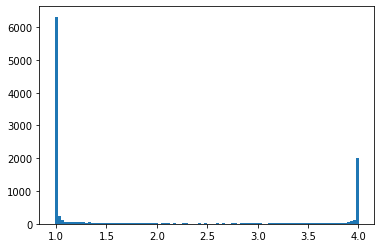

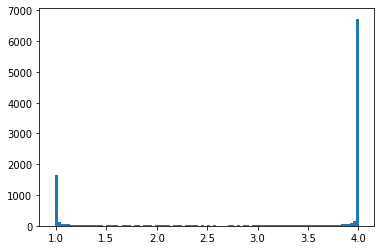

1.0
0.0


In [17]:
plt.hist(predict[validation_y==1],bins=100)
plt.show()
plt.hist(predict[validation_y==4],bins=100)
plt.show()
count = 0
for i in predict[validation_y==4]:
    if i > .5:
        count+=1
print(count/len(validation_y[validation_y==4]))

count = 0
for i in predict[validation_y==1]:
    if i <= .5:
        count+=1
print(count/len(validation_y[validation_y==1]))

In [18]:
index = range(len(validation_energy))
array_split = np.array_split(sorted(list(zip(index,validation_energy)),key=lambda x:x[1]),20)

In [19]:
model = load_model('Mass_model_best.h5')
x = []
y_proton = []
y_iron = []
for i in array_split:
    index1 = []
    for k in list(zip(*i))[0]:
        index1.append(int(k))
    energy = validation_energy[index1]
    mass1 = validation_y[index1]
    data = validation_x[index1]
    #prediction1 = prediction_model(data)
    prediction1 = dnns_classifier.predict(data)
    prediction = np.hstack(prediction1)
    
    for j in range(len(prediction1)):
        if prediction1[j] < 2.5:
            prediction1[j] = 1
        else:
            prediction1[j] = 4
    cm = confusion_matrix(mass1,prediction1)
    x.append((max(energy)+min(energy))/2)
    y_proton.append(cm[0][0]/np.sum(cm[0]))
    y_iron.append(cm[1][1]/np.sum(cm[1]))

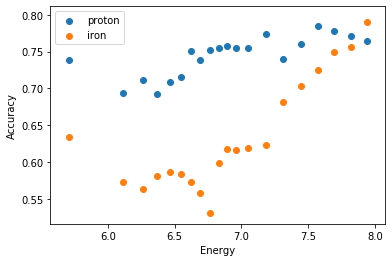

In [20]:
plt.scatter(x,y_proton,label='proton')
plt.scatter(x,y_iron,label='iron')
plt.xlabel('Energy')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Energy_accuracy')

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(input_variable[train_index],train_labels)
knn_predictions=knn_classifier.predict(input_variable[test_index])

In [29]:
cm = confusion_matrix(test_labels,knn_predictions)
print(cm[0][0]/np.sum(cm[0]),cm[1][1]/np.sum(cm[1]))

0.7373632100052111 0.6983965793693212


In [33]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(input_variable[train_index],train_labels)
rf_predictions = rf_classifier.predict(input_variable[test_index])

In [34]:
cm = confusion_matrix(test_labels,rf_predictions)
print(cm[0][0]/np.sum(cm[0]),cm[1][1]/np.sum(cm[1]))

0.7636268890046899 0.7417423837520043


In [14]:
from sklearn.neural_network import MLPClassifier
snn_classifier = MLPClassifier(hidden_layer_sizes = [16]*5)
snn_classifier.fit(input_variable[train_index],train_labels)
snn_predictions= snn_classifier.predict(input_variable[test_index])

In [40]:
cm = confusion_matrix(test_labels,snn_predictions)
print(cm[0][0]/np.sum(cm[0]),cm[1][1]/np.sum(cm[1]))

0.7779051589369463 0.7452164617851417


In [43]:
from sklearn.svm import SVC
svm_classifier = SVC(decision_function_shape='ovr')
svm_classifier.fit(input_variable[train_index],train_labels)
svm_predicitons_labels = svm_classifier.predict(input_variable[test_index])

In [45]:
cm = confusion_matrix(test_labels,svm_predicitons_labels)
print(cm[0][0]/np.sum(cm[0]),cm[1][1]/np.sum(cm[1]))

0.771235018238666 0.7466060929983965


In [15]:
from sklearn.multiclass import OneVsRestClassifier
dnns_classifier = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes = [16]*5,solver='adam',learning_rate='adaptive',max_iter=300,early_stopping=True))
dnns_classifier.fit(input_variable[train_index],train_labels)
dnns_predictions_labels = dnns_classifier.predict(input_variable[test_index])

In [16]:
cm = confusion_matrix(test_labels,dnns_predictions_labels)
print(cm[0][0]/np.sum(cm[0]),cm[1][1]/np.sum(cm[1]))

0.7364773319437207 0.6414751469802245


In [54]:
from xgboost import XGBClassifier
xgb_classifier = OneVsRestClassifier(XGBClassifier())
xgb_classifier.fit(input_variable[train_index],train_labels)
xgb_classifier_labels = xgb_classifier.predict(input_variable[test_index])

In [55]:
cm = confusion_matrix(test_labels,xgb_classifier_labels)
print(cm[0][0]/np.sum(cm[0]),cm[1][1]/np.sum(cm[1]))

0.7707139134966128 0.7451630144307857
